## LIBRERIAS

In [23]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from tqdm import tqdm

## CARGA Y PREPROCESAMIENTO

In [24]:
df = pd.read_excel("datosRed.xlsx")

In [25]:
print(f"Total de registros: {len(df)}")

Total de registros: 10384


In [26]:
df['PERSONA'] = df['PERSONA'].astype(str).str.strip().str.upper()
df['AÑO'] = df['AÑO'].astype(int)
df['TIPO DE SERVICIO'] = df['TIPO DE SERVICIO'].astype(str).str.strip().str.upper()
df['NOMBRE DE LA TAREA'] = df['NOMBRE DE LA TAREA'].astype(str).str.strip().str.upper()
df['MODALIDAD'] = df['MODALIDAD'].astype(str).str.strip().str.upper()
df['COMPLEJIDAD'] = df['COMPLEJIDAD'].astype(str).str.strip().str.upper()
df['UNIDAD_CONSUMO'] = df['TIPO DE SERVICIO'] + '_' + df['NOMBRE DE LA TAREA']

In [27]:
df.drop_duplicates(inplace=True)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7955 entries, 0 to 10379
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   AÑO                 7955 non-null   int64 
 1   PERSONA             7955 non-null   object
 2   TIPO DE SERVICIO    7955 non-null   object
 3   NOMBRE DE LA TAREA  7955 non-null   object
 4   MODALIDAD           7955 non-null   object
 5   COMPLEJIDAD         7955 non-null   object
 6   UNIDAD_CONSUMO      7955 non-null   object
dtypes: int64(1), object(6)
memory usage: 497.2+ KB


In [29]:
print(f"Años disponibles: {df['AÑO'].unique()}")

Años disponibles: [2019 2020 2021 2022 2023 2024]


## CONSTRUCCION DE REDES

In [30]:
def build_networks_comprehensive(df_year):
    clientes = df_year['PERSONA'].astype('category')
    servicios = df_year['UNIDAD_CONSUMO'].astype('category')
    
    # Red Bipartita
    B = nx.Graph()
    B.add_nodes_from(clientes.cat.categories, bipartite=0, node_type='cliente')
    B.add_nodes_from(servicios.cat.categories, bipartite=1, node_type='servicio')
    
    for _, row in df_year.iterrows():
        B.add_edge(row['PERSONA'], row['UNIDAD_CONSUMO'])
    
    # Cliente-Cliente
    row = clientes.cat.codes
    col = servicios.cat.codes
    data = np.ones(len(df_year))
    M = csr_matrix((data, (row, col)), 
                   shape=(clientes.cat.categories.size, servicios.cat.categories.size))
    
    co_matrix_clientes = M.dot(M.T)
    G_clientes = nx.Graph()
    G_clientes.add_nodes_from(clientes.cat.categories)
    
    coo = co_matrix_clientes.tocoo()
    for i, j, w in zip(coo.row, coo.col, coo.data):
        if i < j and w > 0:
            G_clientes.add_edge(
                clientes.cat.categories[i], 
                clientes.cat.categories[j], 
                weight=int(w)
            )
    
    # Servicio-Servicio
    co_matrix_servicios = M.T.dot(M)
    G_servicios = nx.Graph()
    G_servicios.add_nodes_from(servicios.cat.categories)
    
    coo_serv = co_matrix_servicios.tocoo()
    for i, j, w in zip(coo_serv.row, coo_serv.col, coo_serv.data):
        if i < j and w > 0:
            G_servicios.add_edge(
                servicios.cat.categories[i], 
                servicios.cat.categories[j], 
                weight=int(w)
            )
    
    return B, G_clientes, G_servicios

In [31]:
redes_anuales = {}
for year in sorted(df['AÑO'].unique()):
    df_year = df[df['AÑO'] == year].copy()
    B, G_clientes, G_servicios = build_networks_comprehensive(df_year)
    redes_anuales[year] = {
        'bipartita': B,
        'clientes': G_clientes,
        'servicios': G_servicios
    }
    print(f"\n{year}:")
    print(f"  Bipartita: {B.number_of_nodes()} nodos, {B.number_of_edges()} enlaces")
    print(f"  Clientes: {G_clientes.number_of_nodes()} nodos, {G_clientes.number_of_edges()} enlaces")
    print(f"  Servicios: {G_servicios.number_of_nodes()} nodos, {G_servicios.number_of_edges()} enlaces")


2019:
  Bipartita: 299 nodos, 298 enlaces
  Clientes: 298 nodos, 44253 enlaces
  Servicios: 1 nodos, 0 enlaces

2020:
  Bipartita: 816 nodos, 941 enlaces
  Clientes: 806 nodos, 163332 enlaces
  Servicios: 10 nodos, 28 enlaces

2021:
  Bipartita: 2397 nodos, 2840 enlaces
  Clientes: 2386 nodos, 1284882 enlaces
  Servicios: 11 nodos, 33 enlaces

2022:
  Bipartita: 1568 nodos, 1902 enlaces
  Clientes: 1557 nodos, 557238 enlaces
  Servicios: 11 nodos, 28 enlaces

2023:
  Bipartita: 727 nodos, 1207 enlaces
  Clientes: 711 nodos, 98563 enlaces
  Servicios: 16 nodos, 57 enlaces

2024:
  Bipartita: 388 nodos, 598 enlaces
  Clientes: 375 nodos, 23155 enlaces
  Servicios: 13 nodos, 51 enlaces


## RESULTADOS DE METRICAS

In [ ]:
def calcular_metricas_red(G, tipo_red=""):
    N = G.number_of_nodes()
    M = G.number_of_edges()
    
    if N <= 1:
        return {
            'N_Nodos': N, 'N_Enlaces': M, 'Grado_Medio': 0,
            'Densidad': 0, 'Clustering': 0, 'Distancia_Media': 0,
            'Diametro': 0, 'Componentes': 0, 'Tamaño_GC': 0
        }
    
    avg_degree = 2 * M / N
    density = nx.density(G)
    clustering = nx.average_clustering(G, weight='weight' if 'weight' in G.edges[list(G.edges())[0]] else None)
    
    components = list(nx.connected_components(G))
    n_components = len(components)
    giant = max(components, key=len)
    G_gc = G.subgraph(giant)
    
    if G_gc.number_of_nodes() > 1:
        avg_path = nx.average_shortest_path_length(G_gc)
        diameter = nx.diameter(G_gc)
    else:
        avg_path = diameter = 0
    
    return {
        'N_Nodos': N,
        'N_Enlaces': M,
        'Grado_Medio': round(avg_degree, 3),
        'Densidad': round(density, 5),
        'Clustering': round(clustering, 3),
        'Distancia_Media': round(avg_path, 3),
        'Diametro': diameter,
        'Componentes': n_components,
        'Tamaño_GC': len(giant)
    }

In [33]:
metricas_clientes = []
metricas_servicios = []
metricas_bipartita = []

for year in tqdm(sorted(redes_anuales.keys()), desc="Calculando métricas"):
    # Red clientes
    m_cli = calcular_metricas_red(redes_anuales[year]['clientes'], "clientes")
    m_cli['AÑO'] = year
    metricas_clientes.append(m_cli)
    
    # Red servicios
    m_serv = calcular_metricas_red(redes_anuales[year]['servicios'], "servicios")
    m_serv['AÑO'] = year
    metricas_servicios.append(m_serv)
    
    # Red bipartita
    B = redes_anuales[year]['bipartita']
    clientes_b = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'cliente']
    servicios_b = [n for n, d in B.nodes(data=True) if d.get('node_type') == 'servicio']
    
    metricas_bipartita.append({
        'AÑO': year,
        'N_Clientes': len(clientes_b),
        'N_Servicios': len(servicios_b),
        'N_Conexiones': B.number_of_edges(),
        'Densidad': round(B.number_of_edges() / (len(clientes_b) * len(servicios_b)), 5) if len(clientes_b) * len(servicios_b) > 0 else 0
    })



Calculando métricas: 100%|██████████| 6/6 [2:06:17<00:00, 1262.89s/it]  


In [34]:
df_metricas_clientes = pd.DataFrame(metricas_clientes)
df_metricas_servicios = pd.DataFrame(metricas_servicios)
df_metricas_bipartita = pd.DataFrame(metricas_bipartita)

print("MÉTRICAS RED CLIENTE-CLIENTE")
display(df_metricas_clientes)

print("MÉTRICAS RED SERVICIO-SERVICIO")
display(df_metricas_servicios)

print("MÉTRICAS RED BIPARTITA CLIENTE-SERVICIO")
display(df_metricas_bipartita)

MÉTRICAS RED CLIENTE-CLIENTE


,N_Nodos,N_Enlaces,Grado_Medio,Densidad,Clustering,Distancia_Media,Diametro,Componentes,Tamaño_GC,AÑO
0,298,44253,297.000,1.00000,1.000,1.000,1,1,298,2019
1,806,163332,405.290,0.50347,0.104,1.504,4,1,806,2020
2,2386,1284882,1077.018,0.45158,0.109,1.551,3,1,2386,2021
3,1557,557238,715.784,0.46002,0.114,1.596,4,2,1556,2022
4,711,98563,277.252,0.39050,0.087,1.625,4,1,711,2023
5,375,23155,123.493,0.33020,0.084,1.704,4,2,373,2024


MÉTRICAS RED SERVICIO-SERVICIO


,N_Nodos,N_Enlaces,Grado_Medio,Densidad,Clustering,Distancia_Media,Diametro,Componentes,Tamaño_GC,AÑO
0,1,0,0.000,0.00000,0.000,0.000,0,0,0,2019
1,10,28,5.600,0.62222,0.078,1.422,3,1,10,2020
2,11,33,6.000,0.60000,0.059,1.400,2,1,11,2021
3,11,28,5.091,0.50909,0.144,1.422,3,2,10,2022
4,16,57,7.125,0.47500,0.104,1.650,4,1,16,2023
5,13,51,7.846,0.65385,0.147,1.242,3,2,12,2024


MÉTRICAS RED BIPARTITA CLIENTE-SERVICIO


,AÑO,N_Clientes,N_Servicios,N_Conexiones,Densidad
0,2019,298,1,298,1.00000
1,2020,806,10,941,0.11675
2,2021,2386,11,2840,0.10821
3,2022,1557,11,1902,0.11105
4,2023,711,16,1207,0.10610
5,2024,375,13,598,0.12267


## VIZUALIZCIONES EXTRA

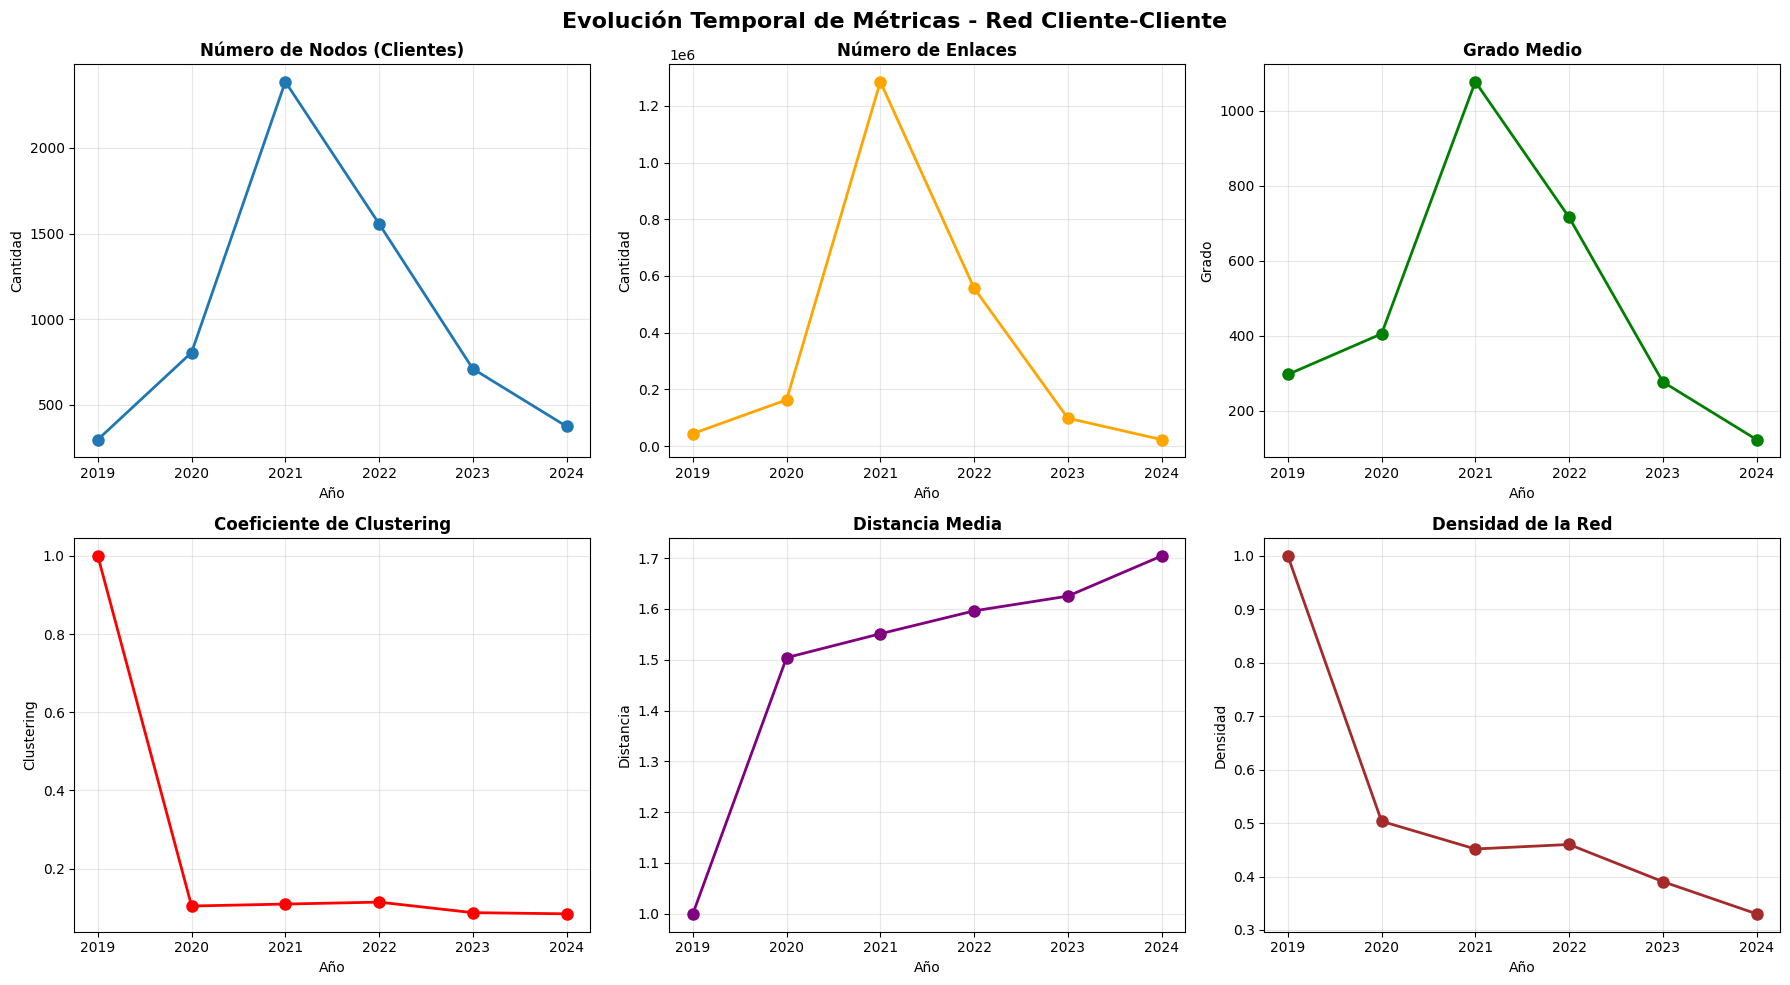

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Evolución Temporal de Métricas - Red Cliente-Cliente', fontsize=16, fontweight='bold')

# Nodos y Enlaces
axes[0, 0].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['N_Nodos'], 'o-', linewidth=2, markersize=8)
axes[0, 0].set_title('Número de Nodos (Clientes)', fontweight='bold')
axes[0, 0].set_xlabel('Año')
axes[0, 0].set_ylabel('Cantidad')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['N_Enlaces'], 'o-', color='orange', linewidth=2, markersize=8)
axes[0, 1].set_title('Número de Enlaces', fontweight='bold')
axes[0, 1].set_xlabel('Año')
axes[0, 1].set_ylabel('Cantidad')
axes[0, 1].grid(True, alpha=0.3)

# Grado Medio
axes[0, 2].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['Grado_Medio'], 'o-', color='green', linewidth=2, markersize=8)
axes[0, 2].set_title('Grado Medio', fontweight='bold')
axes[0, 2].set_xlabel('Año')
axes[0, 2].set_ylabel('Grado')
axes[0, 2].grid(True, alpha=0.3)

# Clustering
axes[1, 0].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['Clustering'], 'o-', color='red', linewidth=2, markersize=8)
axes[1, 0].set_title('Coeficiente de Clustering', fontweight='bold')
axes[1, 0].set_xlabel('Año')
axes[1, 0].set_ylabel('Clustering')
axes[1, 0].grid(True, alpha=0.3)

# Distancia Media
axes[1, 1].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['Distancia_Media'], 'o-', color='purple', linewidth=2, markersize=8)
axes[1, 1].set_title('Distancia Media', fontweight='bold')
axes[1, 1].set_xlabel('Año')
axes[1, 1].set_ylabel('Distancia')
axes[1, 1].grid(True, alpha=0.3)

# Densidad
axes[1, 2].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['Densidad'], 'o-', color='brown', linewidth=2, markersize=8)
axes[1, 2].set_title('Densidad de la Red', fontweight='bold')
axes[1, 2].set_xlabel('Año')
axes[1, 2].set_ylabel('Densidad')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

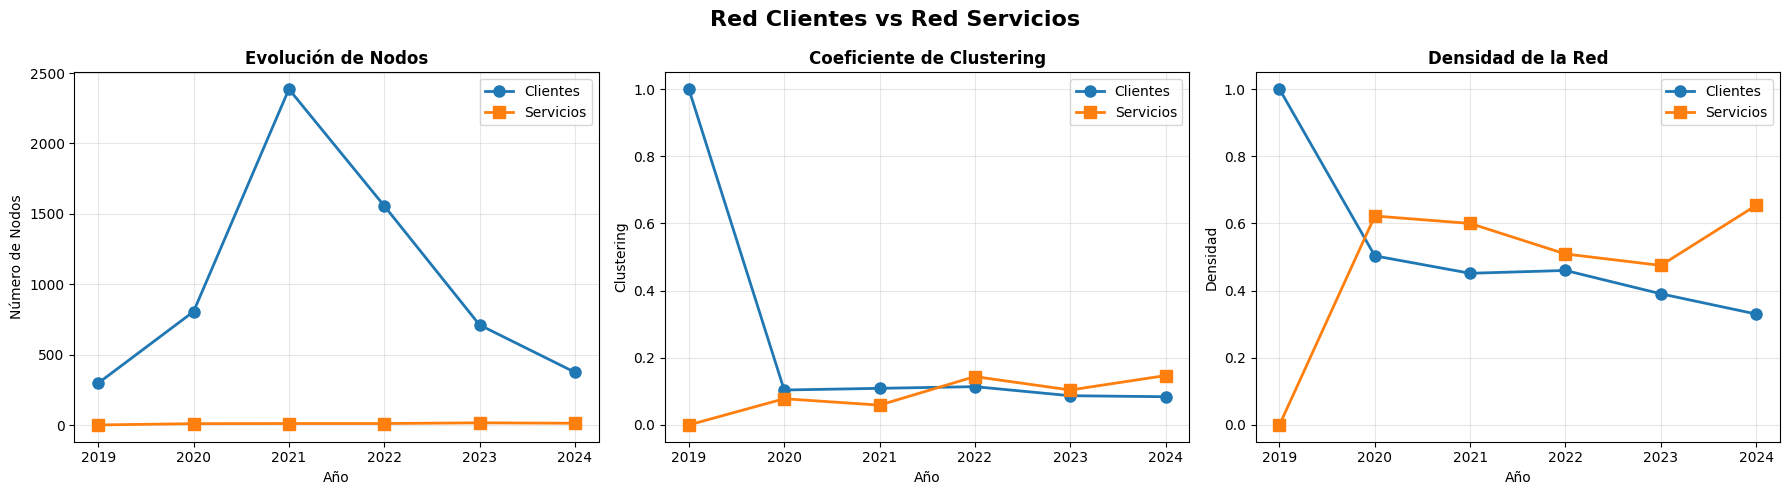

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Red Clientes vs Red Servicios', fontsize=16, fontweight='bold')

# Número de nodos
axes[0].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['N_Nodos'], 'o-', label='Clientes', linewidth=2, markersize=8)
axes[0].plot(df_metricas_servicios['AÑO'], df_metricas_servicios['N_Nodos'], 's-', label='Servicios', linewidth=2, markersize=8)
axes[0].set_title('Evolución de Nodos', fontweight='bold')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Número de Nodos')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Clustering
axes[1].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['Clustering'], 'o-', label='Clientes', linewidth=2, markersize=8)
axes[1].plot(df_metricas_servicios['AÑO'], df_metricas_servicios['Clustering'], 's-', label='Servicios', linewidth=2, markersize=8)
axes[1].set_title('Coeficiente de Clustering', fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Clustering')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Densidad
axes[2].plot(df_metricas_clientes['AÑO'], df_metricas_clientes['Densidad'], 'o-', label='Clientes', linewidth=2, markersize=8)
axes[2].plot(df_metricas_servicios['AÑO'], df_metricas_servicios['Densidad'], 's-', label='Servicios', linewidth=2, markersize=8)
axes[2].set_title('Densidad de la Red', fontweight='bold')
axes[2].set_xlabel('Año')
axes[2].set_ylabel('Densidad')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

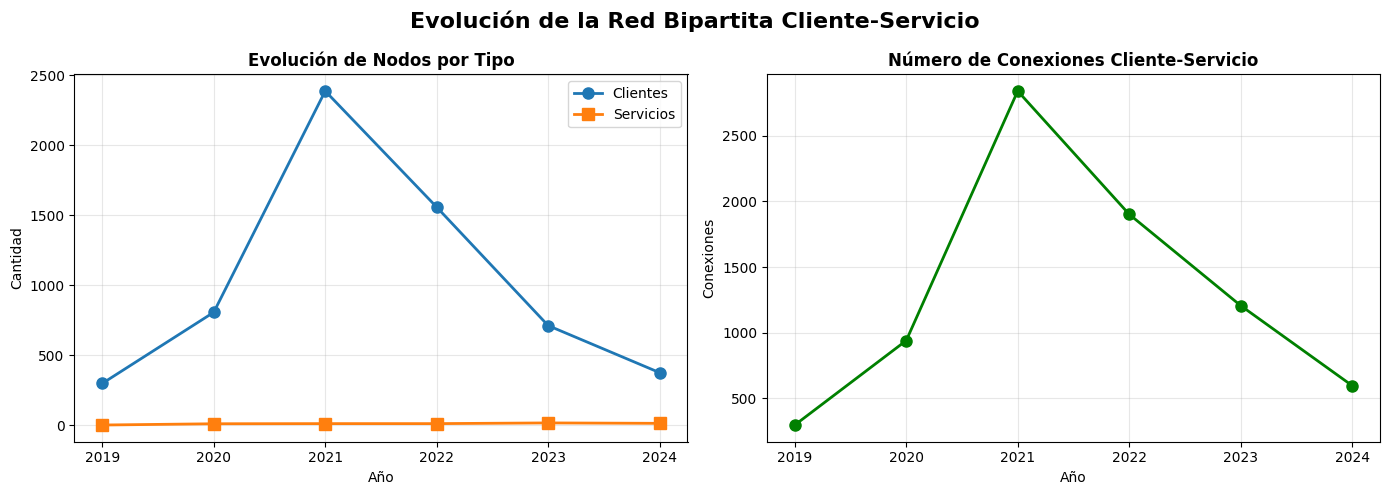

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Evolución de la Red Bipartita Cliente-Servicio', fontsize=16, fontweight='bold')

axes[0].plot(df_metricas_bipartita['AÑO'], df_metricas_bipartita['N_Clientes'], 'o-', label='Clientes', linewidth=2, markersize=8)
axes[0].plot(df_metricas_bipartita['AÑO'], df_metricas_bipartita['N_Servicios'], 's-', label='Servicios', linewidth=2, markersize=8)
axes[0].set_title('Evolución de Nodos por Tipo', fontweight='bold')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Cantidad')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_metricas_bipartita['AÑO'], df_metricas_bipartita['N_Conexiones'], 'o-', color='green', linewidth=2, markersize=8)
axes[1].set_title('Número de Conexiones Cliente-Servicio', fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Conexiones')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

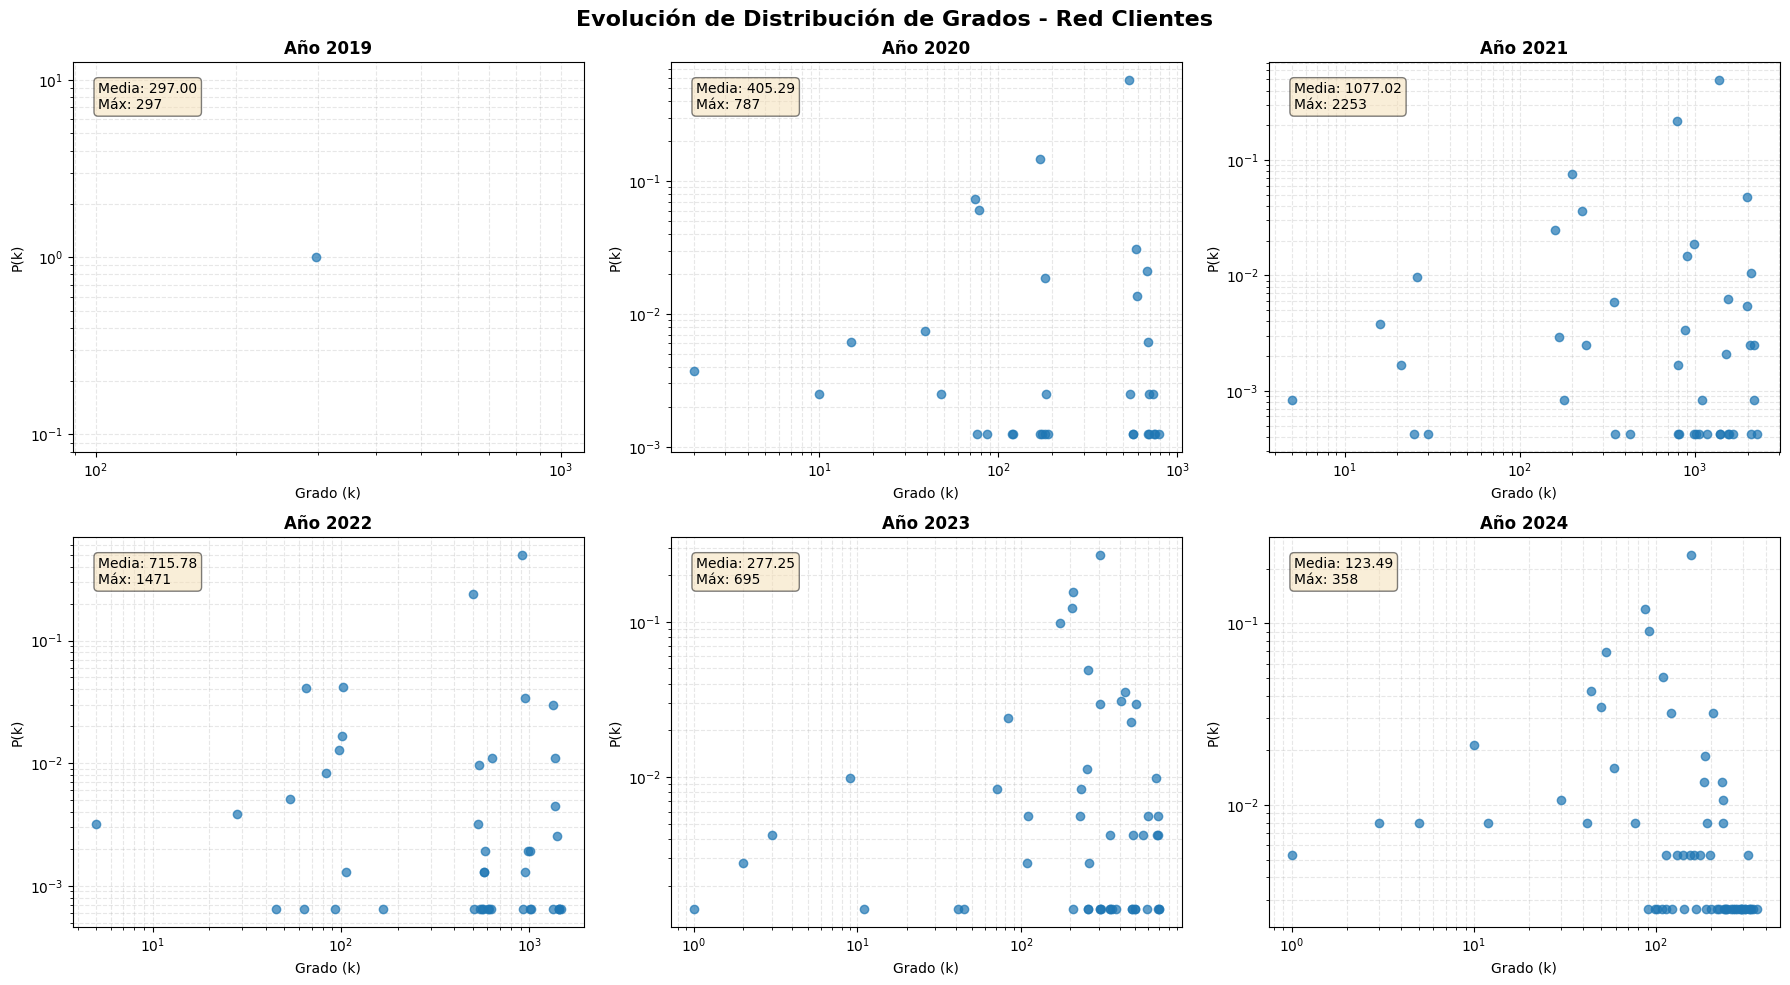

C:\Users\Administrador\AppData\Local\Temp\ipykernel_18732\3850713989.py:34: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


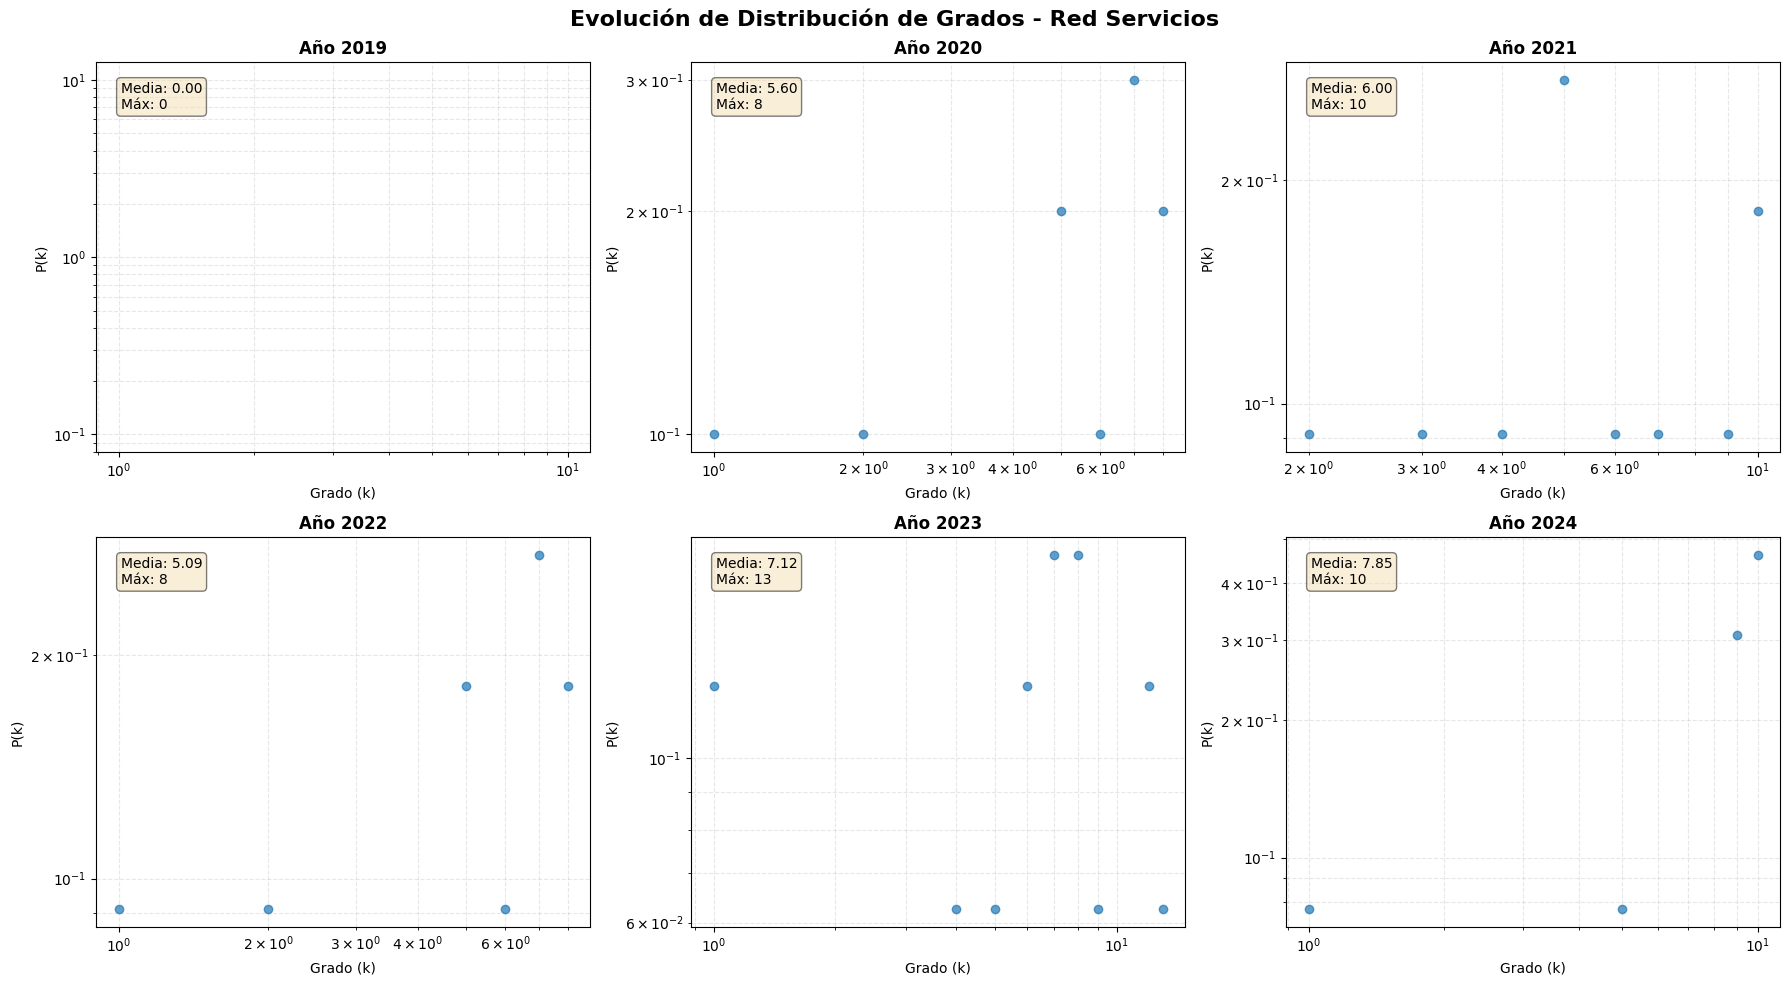

In [ ]:
def plot_degree_distributions_evolution(redes_dict, tipo_red='clientes'):
    years = sorted(redes_dict.keys())
    n_years = len(years)
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Evolución de Distribución de Grados - Red {tipo_red.capitalize()}', 
                 fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    for idx, year in enumerate(years):
        G = redes_dict[year][tipo_red]
        degs = [d for n, d in G.degree()]
        
        if len(degs) == 0:
            continue
            
        counts = pd.Series(degs).value_counts().sort_index()
        pk = counts / len(degs)
        
        axes[idx].loglog(pk.index, pk.values, 'o', alpha=0.7, markersize=6)
        axes[idx].set_title(f'Año {year}', fontweight='bold')
        axes[idx].set_xlabel('Grado (k)')
        axes[idx].set_ylabel('P(k)')
        axes[idx].grid(True, which="both", ls="--", alpha=0.3)
        
        mean_deg = np.mean(degs)
        max_deg = np.max(degs)
        axes[idx].text(0.05, 0.95, f'Media: {mean_deg:.2f}\nMáx: {max_deg}', 
                      transform=axes[idx].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

plot_degree_distributions_evolution(redes_anuales, 'clientes')
plot_degree_distributions_evolution(redes_anuales, 'servicios')

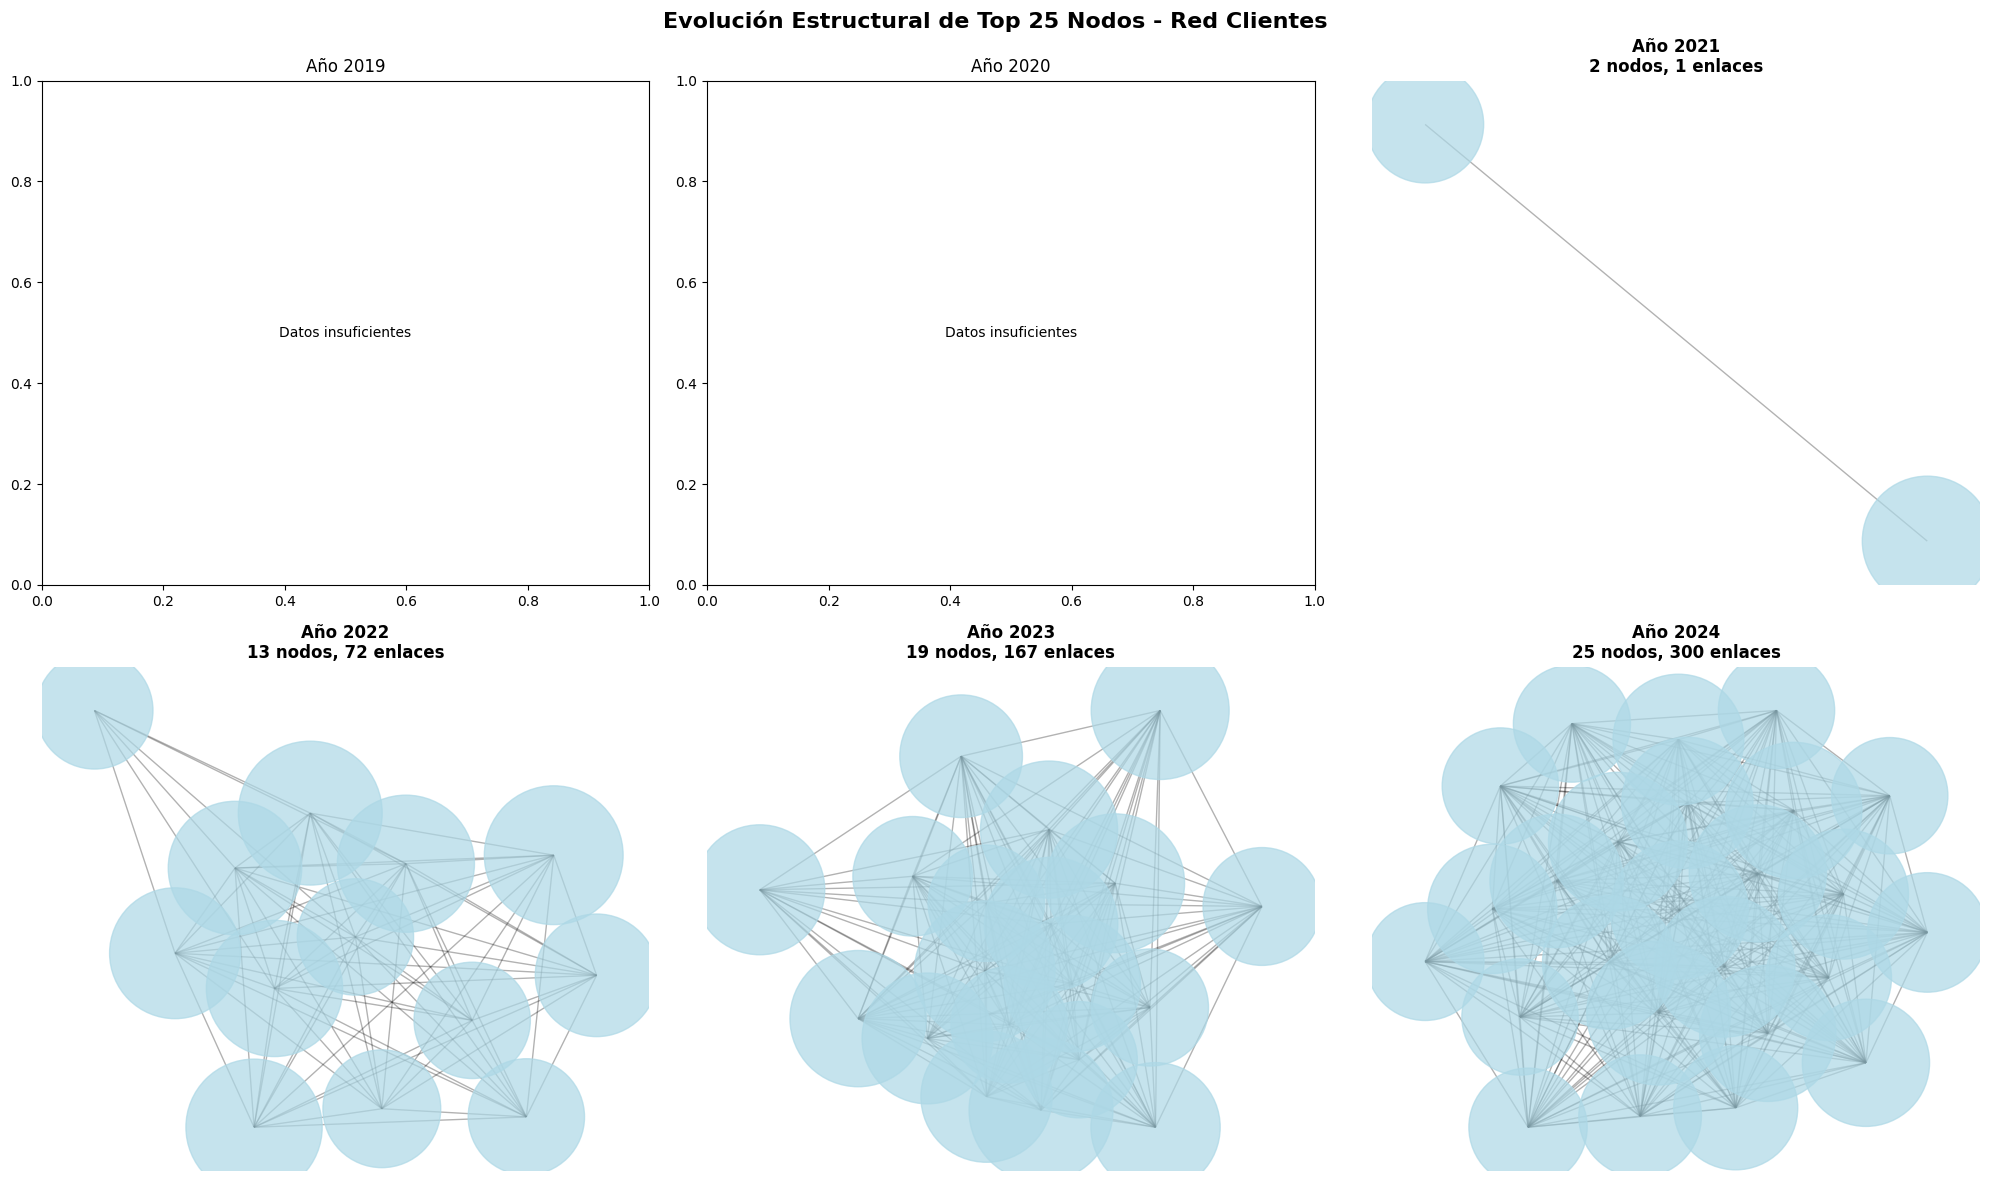

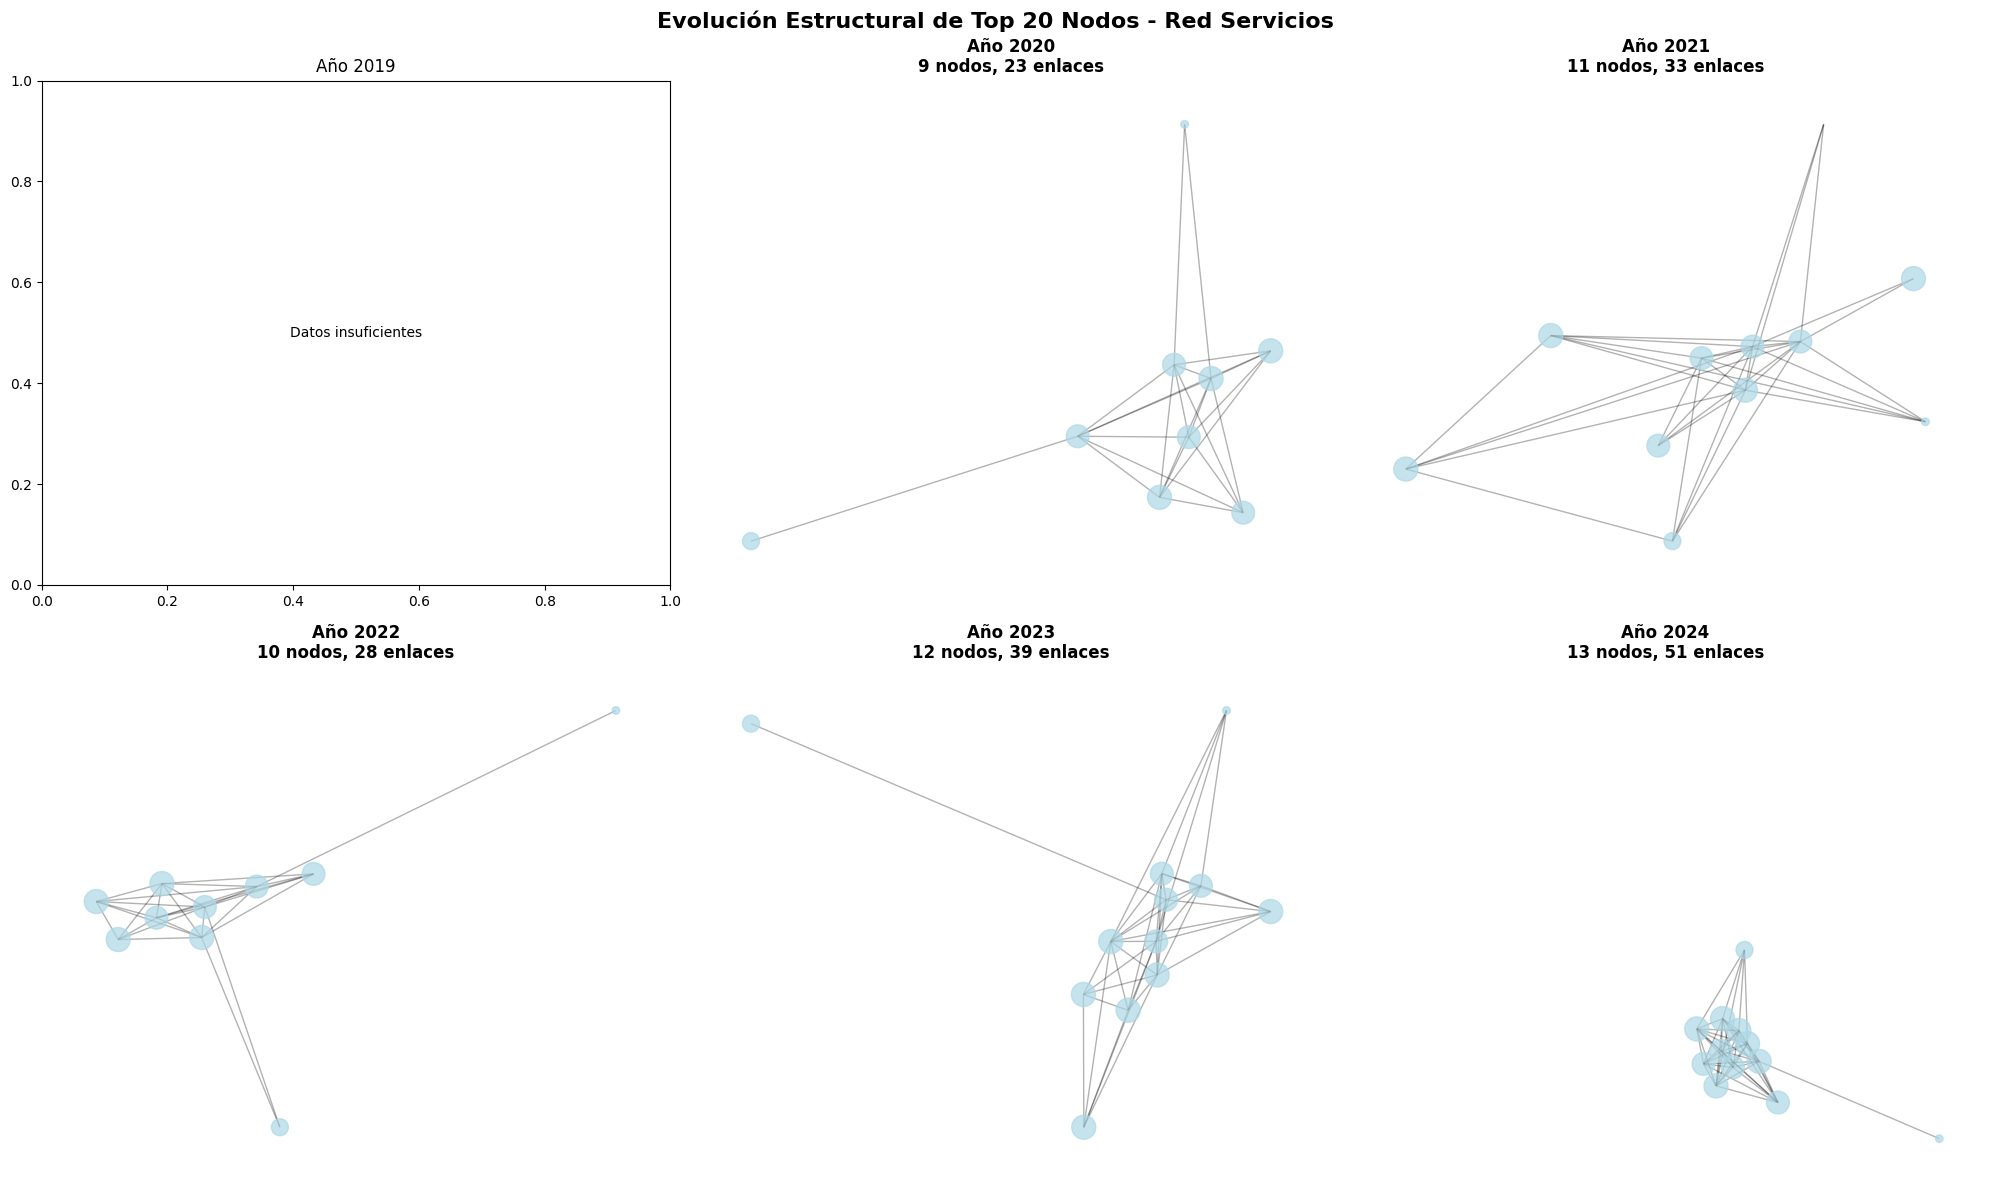

In [ ]:
def visualizar_subgrafo_evolucion(redes_dict, tipo_red='clientes', top_n=30):
    years = sorted(redes_dict.keys())
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle(f'Evolución Estructural de Top {top_n} Nodos - Red {tipo_red.capitalize()}', 
                 fontsize=16, fontweight='bold')
    
    axes = axes.flatten()
    
    G_ultimo = redes_dict[years[-1]][tipo_red]
    degrees_ultimo = dict(G_ultimo.degree())
    top_nodes = sorted(degrees_ultimo, key=degrees_ultimo.get, reverse=True)[:top_n]
    
    for idx, year in enumerate(years):
        G = redes_dict[year][tipo_red]
        
        nodes_presentes = [n for n in top_nodes if n in G.nodes()]
        if len(nodes_presentes) < 2:
            axes[idx].text(0.5, 0.5, 'Datos insuficientes', ha='center', va='center')
            axes[idx].set_title(f'Año {year}')
            continue
            
        subG = G.subgraph(nodes_presentes)
        
        pos = nx.spring_layout(subG, k=0.5, iterations=50, seed=42)
        
        node_sizes = [degrees_ultimo.get(n, 1) * 30 for n in subG.nodes()]
        nx.draw_networkx_nodes(subG, pos, node_size=node_sizes, 
                               node_color='lightblue', alpha=0.7, ax=axes[idx])
        nx.draw_networkx_edges(subG, pos, alpha=0.3, ax=axes[idx])
        
        axes[idx].set_title(f'Año {year}\n{subG.number_of_nodes()} nodos, {subG.number_of_edges()} enlaces', 
                           fontweight='bold')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

visualizar_subgrafo_evolucion(redes_anuales, 'clientes', top_n=25)
visualizar_subgrafo_evolucion(redes_anuales, 'servicios', top_n=20)